<a href="https://colab.research.google.com/github/Alice1304/1day1commit/blob/main/%EC%8B%A4%EC%8A%B5/SECTION4/N434.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## DCGAN (Deep Convolution GAN) 으로 모델 구조 이해하기 

1. 라이브러리 import

In [1]:
from tensorflow.keras import layers
from IPython import display

import glob
import imageio
import os
import PIL
import time

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

2. 데이터셋 불러오기 + 정규화하기 

In [2]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()  #test 데이터 사용하지 않음

11501568/11490434 [==============================] - 0s 0us/step


In [3]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

In [4]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [5]:
# 데이터 배치를 만들고 섞습니다.
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

3. 모델구축하기 - 생성자 

In [6]:
def make_generator_model():
    """
    모델을 구축하는 함수입니다.
    """
    model = tf.keras.Sequential() 
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,))) #은닉층 사이즈 7X7X256
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())            #은닉층의 활성화 함수는 Relu함수의 변형인 LeakyReLU함수 사용, 활성화 함수 이전에 배치 정규화 적용

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # 주목: 배치사이즈로 None이 주어집니다.

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))   #Random Noise로부터 이미지를 생성하기 위해 Transpose convolution 사용- Upsampling 수행// 
    assert model.output_shape == (None, 7, 7, 128)                                                        #dense층 은 Randomnoise 를 입력받아, 28x28이 나오도록 Conv2Dtranspose 를 겹겹이 쌓기 
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

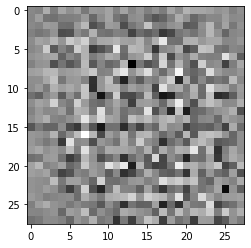

In [7]:
#훈련을 진행하지 않은 생성자를 이용해 이미지를 생성하기 

generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

4. 모델구축하기 - 판별자

In [8]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))  #합성곱 신경망(Convolutional Neural Network, CNN) 기반의 이미지 분류기
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [9]:
#훈련을 진행하지 않은 생성자를 이용해 이미지가 진짜인지 / 가짜인지 판별하기 
#실제 이미지에는 양수를, 가짜에는 음수 출력 훈련

discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.00437457]], shape=(1, 1), dtype=float32)


5. 손실 함수와 옵티마이저 정의하기 


- 생성자와 판별자의 손실 함수를 정의합니다.

- 판별자의 손실함수는 real_loss와 fake_loss를 더한 값입니다.
- real_loss의 경우 전체가 1인 행렬과 real_output을 비교하여 구하며
- fake_loss의 경우 전체가 0인 행렬과 fake_output을 비교하여 구합니다.

- 생성자의 손실 함수는 전체가 1인 행렬과 fake_output을 비교하여 구합니다.

In [10]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [11]:
def discriminator_loss(real_output, fake_output):
    """
    
    """
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [12]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [13]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4) #옵티마이저 - ADAM 사용 
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

6. 모델이 저장되는 Checkpoint 설정 



In [14]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


7. 훈련 루프 지정하기 


- 생성자가 입력으로 Random Noise 를 입력받습니다.
- 입력받은 Random Noise 를 사용하여 이미지를 생성합니다.
- 판별자를 사용하여 Train 데이터셋의 진짜 이미지와 생성자가 만들어낸 가짜 이미지를 분류합니다.
- 각 모델의 손실을 계산하고, 경사 하강법과 역전파를 통해 가중치를 업데이트합니다.

In [15]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [16]:
#각 iteration마다 어떻게 각 모델이 갱신되는 지에 대한 함수 정의


@tf.function
def train_step(images):
    """
    위에서 정의한 손실함수를 바탕으로
    Iteration(=step) 마다 가중치를 갱신합니다.

    Args:
        images: 훈련 데이터셋에 있는 실제 이미지입니다.
    """
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
 
        gen_loss = generator_loss(fake_output)   #생성자
        disc_loss = discriminator_loss(real_output, fake_output) #판별자

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [17]:
#중간결과를 얻기 위해 생성된 이미지를 출력하고 저장하는 함수 정의


def generate_and_save_images(model, epoch, test_input):
    """
    모델이 이미지를 생성한 후 저장하는 함수입니다.
    
    Args:
        model: 이미지를 생성할 모델입니다.
        epoch: 진행 중인 Epoch 숫자입니다.
        test_input: model에 입력되는 데이터입니다.
    """

    # training=False 이면 모든 층이 추론(inference)모드로 진행됩니다.
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [18]:
def train(dataset, epochs):
    """
    학습 중 실행할 동작을 함수로 정의합니다.
    
    Args:
        dataset: (훈련) 데이터셋입니다.
        epochs: 최종 학습 Epoch 입니다.
    """
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # 이미지를 생성한 뒤 저장합니다.(추후에 만들 GIF를 위함입니다.)
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

        # 15 에포크가 지날 때마다 모델을 Checkpoint에 저장합니다.
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
        
        # Epoch 마다 소요 시간을 출력합니다.
        print(f'Time for epoch {epoch + 1} is {time.time()-start} sec')

    # 마지막 에포크가 끝난 후 이미지를 생성합니다.
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

8. 함수를 실행시켜 실제 훈련 진행 

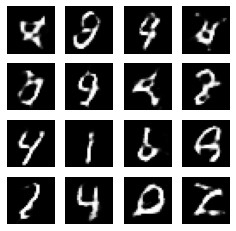

CPU times: user 3min, sys: 31.1 s, total: 3min 31s
Wall time: 12min 38s


In [19]:
%%time
train(train_dataset, EPOCHS)

In [20]:
#마지막 체크포인트 복구

checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

9. gif 생성하기 

In [21]:
def display_image(epoch_no):
    """
    특정 Epoch에 생성된 이미지를 불러오는 함수입니다.

    Args:
        epoch_no: 특정 Epoch에 해당하는 숫자입니다.
    """
    return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

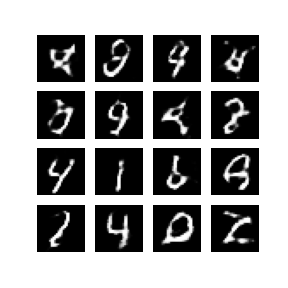

In [22]:
display_image(EPOCHS)